In [1]:
# Semel TLV observational ML analysis
# Determining final deformation based on initial excavation displacement profile
# Critical displacement at base of synagogue (Y)
# Slurry wall displacement profile (X)




In [2]:
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn import svm
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Perceptron
from sklearn.metrics import mean_squared_error, r2_score


# Generation of WDP from RS2 result files

In [3]:
# Wall displacement profile nodes from FE model
Profile=[1649, 6316, 1650, 5035, 1651, 6029, 1652, 6027, 1653, 5024, 1654,  5012, 1656, 1657, 1659, 1661, 1662, 1664, 
          4972, 1666, 4958, 1667, 4958, 1668, 4952]
# removed: 5019, 4978, 371 that caused outliers 

In [ ]:
#inputs according to size of MC analysis
l=999 # number of RS2 models (samples)
nos=l # number of samples for each variable
n=len(Profile) # number of wall displacement profile nodes
# Node 290 stage 4- critical displacement at base of synagogue (Y)
# Node list, stage 3- slurry wall displacement profile (X)


X=np.zeros((l,n)) # WDP in the paper
Xmax=[]
Y=np.zeros(l) # BD in the paper
no_cons=[] # non-converging models
no_con=0

for j in range(l):
    if j<9: # adjust according to number of digits nos
        qq='00'+str(j+1)+ '.r03'
        cc='00'+str(j+1)+ '.log'
        yy='00'+str(j+1)+ '.r04'
    if j>=9 and j<99:     
        qq='0'+str(j+1)+ '.r03'
        cc='0'+str(j+1)+ '.log'
        yy='0'+str(j+1)+ '.r04'
    if j>=99 and j<999:
        qq=str(j+1)+ '.r03'
        cc=str(j+1)+ '.log'
        yy=str(j+1)+ '.r04'
    if j>=999 and j<l+1:
        qq=str(j+1)+ '.r03'
        cc=str(j+1)+ '.log'
        yy=str(j+1)+ '.r04'
    
    path1=r'C:\Users\amichai\Desktop\python_practice\RS2\semel_mc2\\'+qq 
    path2=r'C:\Users\amichai\Desktop\python_practice\RS2\semel_mc2\\'+cc
    path3=r'C:\Users\amichai\Desktop\python_practice\RS2\semel_mc2\\'+yy 
    data=pd.read_fwf(path1, delimiter = ' ') # result file for X
    y_data=pd.read_fwf(path3, delimiter = ' ') # result file for Y
    con=pd.read_fwf(path2, delimiter = ' ') # convergence file
    # checking for non-convergence
    check = np.column_stack([con[col].astype(str).str.contains("Convergence was not established", na=False) for col in con])
    for k in range(len(check)):
        if any(check[k])==True:
            no_cons.append(j+1)
            n_con=no_con+1
            break            
    # horizontal displacement results at tunnel nodes
    for i in range(n): # 
        b=data.iloc[Profile[i]+5, 0] # add 5 to node number according to notebook
        b=b.split()
        b=pd.to_numeric(b)
        # b=((b[1]**2+b[2]**2)**0.5)
        X[j,i]=b[1]
    
    Xmax.append(X[j,:].min())
    
    # Y data: horizontal displacement at basement
    c=y_data.iloc[204+5,0] # add 5 to node number according to notebook
    c=c.split()
    c=pd.to_numeric(c)
    # c=((c[1]**2+c[2]**2)**0.5)
    Y[j]=c[1]
    # X[j,0]=a[j,:].max()
    # X[j,1]=a[j,:].min()




In [33]:
# RS2 input and output loaded from file
# requires updating path to Xrs2 and Yrs2 text files
# X = pd.read_fwf (r'C:\Users\amichai\V1.txt')
# Y = pd.read_fwf (r'C:\Users\amichai\V2.txt')
# X2 = pd.read_fwf (r'C:\Users\amichai\V3.txt')
# convert dataframe to np array
# X=np.array(X)
# Y=np.array(Y)
# X2=np.array(X2)

In [34]:
# checking for non-converging models
no_cons=np.array(no_cons)
no_cons

array([], dtype=float64)

In [35]:
# removing non-converging models from X and Y
if no_con>0:
    X=np.delete(X,no_cons,0)
    Y=np.delete(Y,no_cons,0)
    l=l-len(no_cons)
    nos=l

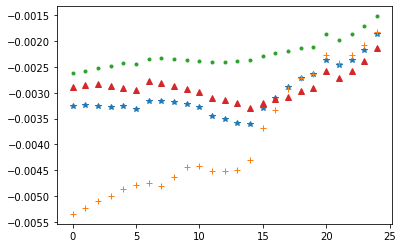

In [36]:
# Sample of WDP plots

# plt.plot(X[32,:])
plt.plot(X[0,:],'*')
plt.plot(X[84,:],'+')
plt.plot(X[6,:],'.')
plt.plot(X[70,:],'^')
# plt.plot(X,'*')
plt.show()

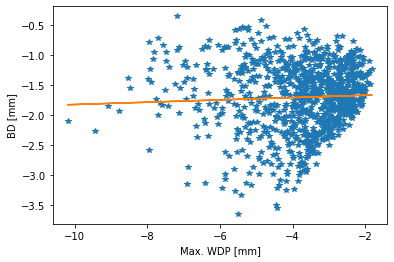

In [37]:
# plot of max. WDP vs. BD. Shows that no correlation exists
Xp=1000*np.array(Xmax)
Yp=1000*np.array(Y)
fig, ax = plt.subplots()
ax.plot(Xp,Yp,'*')
m, b = np.polyfit(Xp,Yp, 1)
model = np.polyfit(Xp, Yp, 1)
predict = np.poly1d(model)
r2_lin=round(r2_score(Yp, predict(Xp)),4)
plt.plot(Xp, m*Xp + b)
plt.xlabel('Max. WDP [mm]')
plt.ylabel('BD [mm]')
plt.rcParams.update({'font.size': 13.5})
model = np.polyfit(Xp, Yp, 1)
# predict = np.poly1d(model)
# ax.annotate('R2='%(), (-9.8, -0.75))
# ax.annotate(r2_lin, (-9.0, -0.75))
plt.show()

In [38]:
# ML defromation prediction of BD based on WDP

# X, Y = shuffle(X, Y)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Random forest model
regr_rf = RandomForestRegressor(max_depth=80, random_state=123)
regr_rf.fit(X_train, y_train)
# Predict on new data
y_rf = regr_rf.predict(X_test)
forestscore=regr_rf.score(X_test, y_test, sample_weight=None)
forestscore

0.7570829592442615

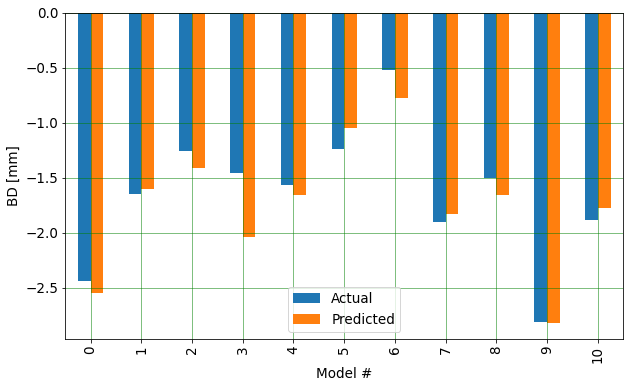

In [39]:
predictions = y_rf
df_temp2 = pd.DataFrame({'Actual': 1000*y_test, 'Predicted': 1000*predictions})
df_temp2 = df_temp2.head(11)
df_temp2.plot(kind='bar',figsize=(10,6))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.xlabel('Model #')
plt.ylabel('BD [mm]')
plt.show()

# Plot of score vs. number of samples

In [40]:
nn=77
initial=30
delta=10
print("max. samples: ", initial+delta*nn)
Forestscore=np.zeros(nn)

max. samples:  800


In [43]:

ll=[]

for i in range(nn):
    j=int(initial+delta*i)
    ll.append(j)
    # X_train, y_train = shuffle(X_train, y_train)
    X_train=X[0:int(0.7*j),:]
    y_train=Y[0:int(0.7*j)]
    X_test=X_test[0:int(0.3*j),:]
    y_test=y_test[0:int(0.3*j)]
    # X_train, X_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.3, random_state=42)
    
    # Random forest model
    regr_rf = RandomForestRegressor(max_depth=50, random_state=0)
    regr_rf.fit(X_train, y_train)
    # Predict on new data
    y_rf = regr_rf.predict(X_test)
    Forestscore[i]=regr_rf.score(X_test, y_test, sample_weight=None)

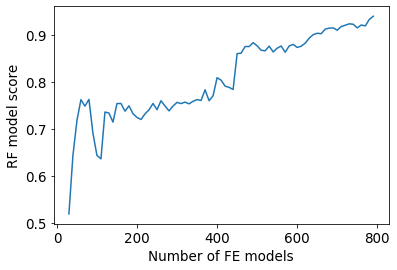

In [45]:
plt.plot(ll, Forestscore,label='forest')
# plt.legend(loc='lower right')
plt.xlabel('Number of FE models')
plt.ylabel('RF model score')
plt.rcParams.update({'font.size': 13.5})
plt.show()

## Data preparation for feature importance

In [53]:
# X2 defined as varied parameters for feature importance
# takes inputs from varsamples and arranges them in X2
d2 = pd.read_fwf (r'C:\Users\amichai\Desktop\python_practice\RS2\semel_mc2\varsamples.txt')
nov=15
l=999
nos=l # adjust if checking subset of models
X2=np.zeros((l,nov))

for i in range(9,9+l):
    for j in range(nov):
        yy=d2.iloc[i+j*(nos+8),0]
        yy=pd.to_numeric(yy)
        X2[i-9,j]=yy


In [54]:
V1=X
np.savetxt('V1.txt',V1)
V2=Y
np.savetxt('V2.txt',V2)
V3=X2
np.savetxt('V3.txt',V3)

In [55]:
# ML feature importance, input parameters against BD

X2, Y = shuffle(X2, Y)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, Y, test_size=0.3, random_state=42)

# Random forest model
regr_rf = RandomForestRegressor(max_depth=60, random_state=0)
regr_rf.fit(X_train2, y_train2)
# Predict on new data
y_rf = regr_rf.predict(X_test2)
forestscore2=regr_rf.score(X_test2, y_test2, sample_weight=None)
forestscore2

0.876016237857709

In [ ]:
Kurkar 2,  Young's Modulus
Kurkar 2,  Friction Angle (peak)
Kurkar 2,  Cohesion (peak)
Kurkar 2,  Friction Angle (residual)
Kurkar 2,  Cohesion (residual)
Fill,  Young's Modulus
Fill,  Friction Angle (peak)
Kurkar E
Kurkar,  Friction Angle (peak)
Kurkar,  Cohesion (peak)
Kurkar,  Friction Angle (residual)
Joint 1,  Normal Stiffness
Joint 1,  Shear Stiffness
Joint 1,  Friction Angle
Effective Stress Ratio (in plane


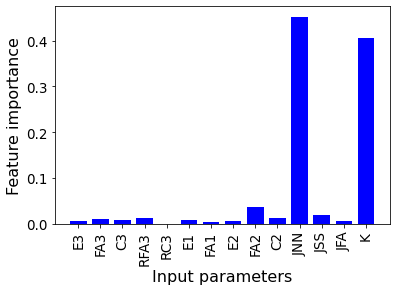

In [58]:
if forestscore2>0.4:
    # feature importance
    fi=regr_rf.feature_importances_
    data = {'E3':fi[0], 'FA3':fi[1], 'C3':fi[2],
            'RFA3':fi[3], 'RC3':fi[4], 'E1':fi[5],
           'FA1':fi[6], 'E2':fi[7], 'FA2':fi[8],
           'C2':fi[9], 'FA2':fi[10], 'JNN':fi[11],
           'JSS':fi[12], 'JFA':fi[13], 'K':fi[14]}
    models = list(data.keys())
    values = list(data.values())
    plt.bar(models, values, color ='Blue', width = 0.75)
    plt.xticks(rotation=90)
    plt.xlabel("Input parameters", fontsize=16)
    plt.ylabel("Feature importance", fontsize=16)

In [402]:
regr_rf.predict(X2[[0]])

array([-0.00141931])

In [403]:
Y[0]

-0.0014347